<a href="https://colab.research.google.com/github/mike1336git/colab_notebook/blob/main/MLstudy/MLstudy03_cnn_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# copy of cnn.ipynb / Copyright 2019 The TensorFlow Authors.


##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## 畳み込みニューラルネットワーク (Convolutional Neural Networks)

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/cnn.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、MNIST の数の分類をするための、シンプルな[畳み込みニューラルネットワーク](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN: Convolutional Neural Network) の学習について説明します。このシンプルなネットワークは MNIST テストセットにおいて、99%以上の精度を達成します。このチュートリアルでは、[Keras Sequential API](https://www.cs.toronto.edu/~kriz/cifar.html)を使用するため、ほんの数行のコードでモデルの作成と学習を行うことができます。<br>Note: GPU を使うことで CNN をより早く学習させることができます。もし、このノートブックを Colab で実行しているならば、編集 -&gt; ノートブックの設定 -&gt; ハードウェアアクセラレータ -&gt; GPU から無料のGPUを有効にすることができます。


### TensorFlowのインポート

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### MNISTデータセットのダウンロードと準備

CIFAR10 データセットには、10 のクラスに 60,000 のカラー画像が含まれ、各クラスに 6,000 の画像が含まれています。 データセットは、50,000 のトレーニング画像と 10,000 のテスト画像に分割されています。クラスは相互に排他的であり、それらの間に重複はありません。

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### データを確認する

データセットが正しいことを確認するために、トレーニングセットの最初の 25 枚の画像をプロットし、各画像の下にクラス名を表示しましょう。


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### 畳み込みの基礎部分の作成

下記の6行のコードは、一般的なパターンで畳み込みの基礎部分を定義しています: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) と [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) レイヤーのスタック。

入力として、CNNはバッチサイズを無視して、形状（image_height、image_width、color_channels）のテンソルを取ります。これらのディメンションを初めて使用する場合、color_channelsは（R,G,B）を参照します。 この例では、CIFAR　画像の形式である形状（32, 32, 3）の入力を処理するようにCNNを構成します。これを行うには、引数`input_shape`を最初のレイヤーに渡します。


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

これまでのモデルのアーキテクチャを表示します。

In [ ]:
model.summary()

上記より、すべての Conv2D と MaxPooling2D レイヤーの出力は shape (height, width, channels) の 3D テンソルであることがわかります。width と height の寸法は、ネットワークが深くなるにつれて縮小する傾向があります。各 Conv2D レイヤーの出力チャネルの数は、第一引数 (例: 32 または 64) によって制御されます。通常、width とheight が縮小すると、各 Conv2D レイヤーにさらに出力チャネルを追加する余裕が (計算上) できます。

### 上に Dense レイヤーを追加

モデルを完成するために、(shape (3, 3, 64) の) 畳み込みの基礎部分からの最後の出力テンソルを、1つ以上の Dense レイヤーに入れて分類を実行します。現在の出力は 3D テンソルですが、Dense レイヤーは入力としてベクトル (1D) を取ります。まず、3D 出力を 1D に平滑化 (または展開) してから、最上部に1つ以上の Dense レイヤーを追加します。MNIST は 10 個の出力クラスを持ちます。そのため、我々は最後の Dense レイヤーの出力を 10 にし、softmax関数を使用します。

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

モデルの完全なアーキテクチャは次のとおりです。

In [ ]:
model.summary()

ネットワークの要約は、(4, 4, 64) 出力が、2 つの高密度レイヤーを通過する前に形状のベクトル (1024) に平坦化されたことを示しています。

### モデルのコンパイルと学習

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

### モデルの評価

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
print(test_acc)

この単純な CNN は、 数行のコードで 70％ を超えるテスト精度を達成しています。別の CNN スタイルについては、Keras サブクラス化 API と{`tf.GradientTape`を使用する[ 上級者向け TensorFlow 2 クイックスタート](https://www.tensorflow.org/tutorials/quickstart/advanced)の例を参照してください。

# try

170498071/170498071 [==============================] - 2s 0us/step


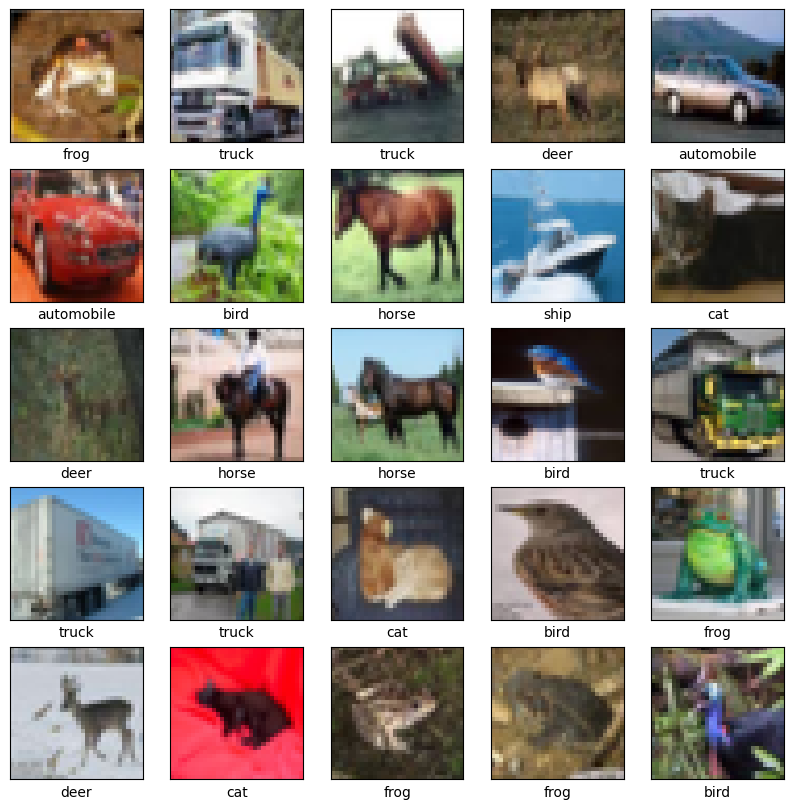

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

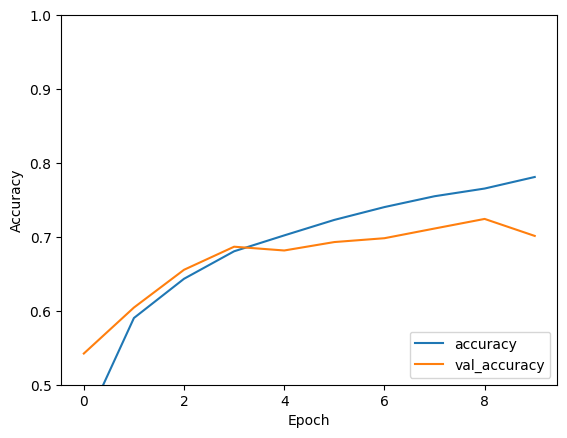

In [ ]:
#@title try 0


import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


# load datasets cifer-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


# show train images 25

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# setup model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()


# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# train
print("")
print("-- train --")
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))


# evaluate
print("")
print("-- evaluate --")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("")
print(test_acc)

print("")
print("-- end --")


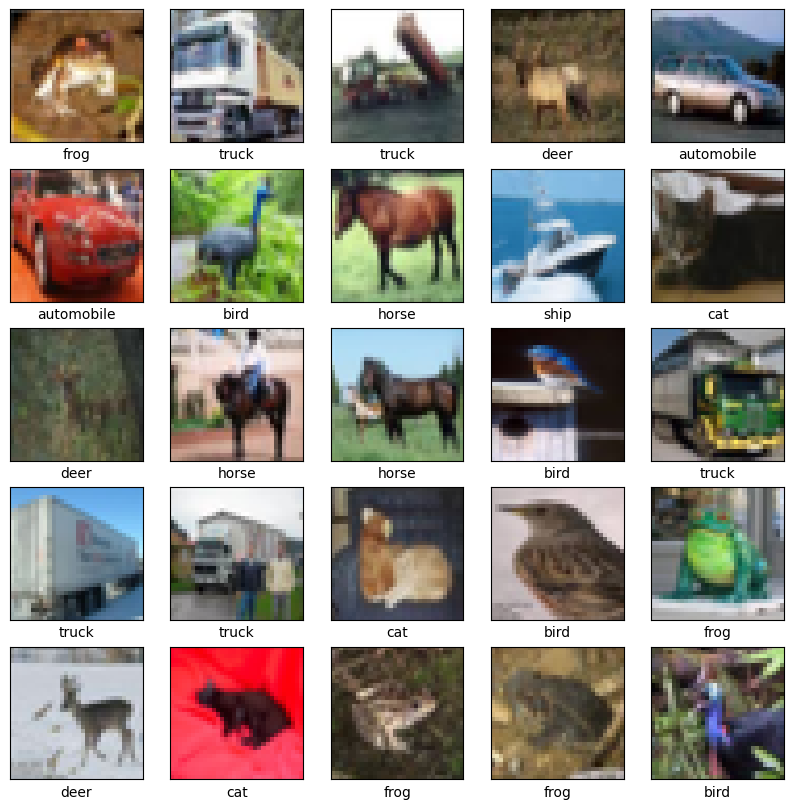

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 1024)             

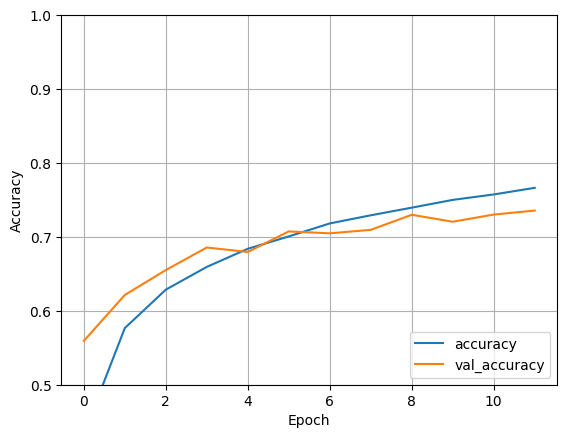

In [ ]:
#@title try 1 add layer.Dropout()


import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


# load datasets cifer-10
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0


# show train images 25

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# setup model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10))

model.summary()


# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


# train
print("")
print("-- train --")
history = model.fit(train_images, train_labels, epochs=12,
                    validation_data=(test_images, test_labels))


# evaluate
print("")
print("-- evaluate --")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.grid()
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print("")
print(test_acc)

print("")
print("-- end --")
